In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the data and get some basic insights from the Training Set

In [7]:
# Load train and test data set
train_data = pd.read_csv('C:/Users/Administrator/Downloads/train-1.csv')
test_data = pd.read_csv('C:/Users/Administrator/Downloads/test-1.csv')
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002717,Male,Yes,0,Graduate,No,1025,5500.0,216.0,360.0,NaN,Rural,Y
1,LP002692,Male,Yes,3+,Graduate,Yes,5677,1424.0,100.0,360.0,1.0,Rural,Y
2,LP002453,Male,No,0,Graduate,Yes,7085,0.0,84.0,360.0,1.0,Semiurban,Y
3,LP002600,Male,Yes,1,Graduate,Yes,2895,0.0,95.0,360.0,1.0,Semiurban,Y
4,LP002862,Male,Yes,2,Not Graduate,No,6125,1625.0,187.0,480.0,1.0,Semiurban,N


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             481 non-null    object 
 2   Married            488 non-null    object 
 3   Dependents         478 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      465 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         473 non-null    float64
 9   Loan_Amount_Term   480 non-null    float64
 10  Credit_History     452 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 50.0+ KB


In [9]:
train_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,491.000000,491.000000,473.000000,480.0000,452.000000
mean,5354.780041,1562.686191,144.355180,342.5250,0.840708
std,6339.972679,2792.527894,81.475461,64.5011,0.366354
min,150.000000,0.000000,9.000000,12.0000,0.000000
25%,2833.000000,0.000000,100.000000,360.0000,1.000000
50%,3813.000000,1041.000000,126.000000,360.0000,1.000000
75%,5699.000000,2227.500000,165.000000,360.0000,1.000000
max,81000.000000,41667.000000,700.000000,480.0000,1.000000


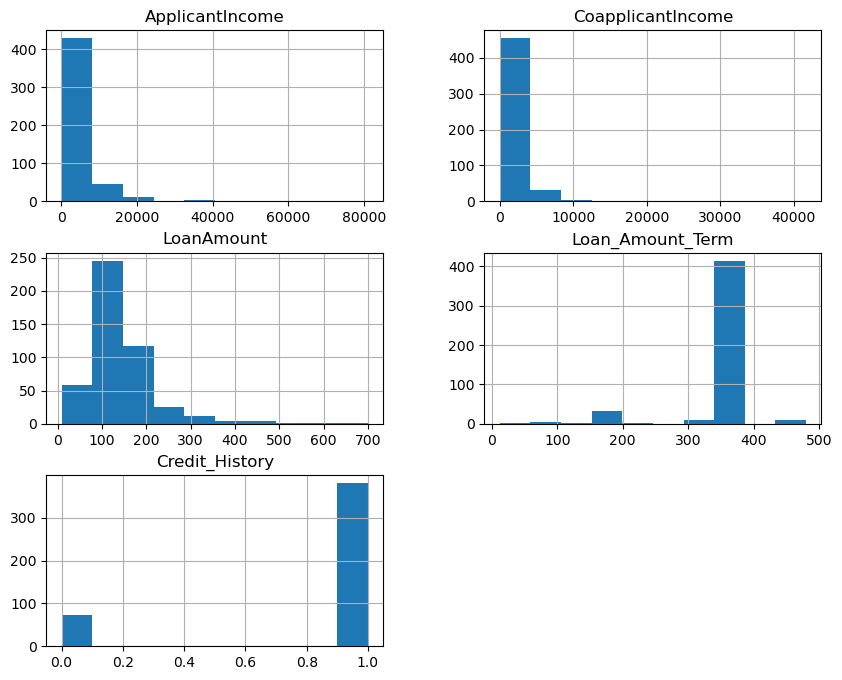

In [10]:
# Generate histograms to check the distribution of numerical features
train_data.hist(figsize=(10,8))
fig = plt.gcf()
fig.savefig('hist.pdf', bbox_inches='tight');

<Axes: xlabel='ApplicantIncome', ylabel='LoanAmount'>

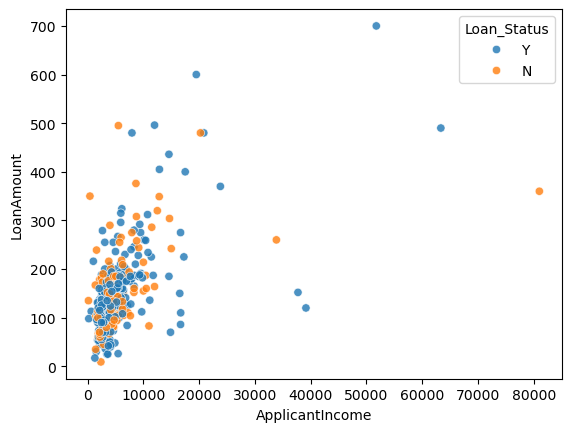

In [11]:
# Use a scatterplot to explore the relationship between applicants' income and their loan amount, and how it differs based on whether  the loan is approved or not
sns.scatterplot(x="ApplicantIncome", y="LoanAmount", data=train_data, hue="Loan_Status", alpha=0.8)

In [12]:
# Check whether the data in the target column is balanced or not
target_column = 'Loan_Status'
train_data[target_column].value_counts()

Loan_Status
Y    337
N    154
Name: count, dtype: int64

EDA results
* The data contains both numerical and categorical variables* 
There are some missing data in the dataset so we may need to fill those using the median value in the numerical columns andthe  most frequent values in the categorcial column
* 
Our target column would be the Loan Status, and we can see at ththe data for that is not balanced, so using an accuracy score to evaluate the model won't be go
* d
From the plot above we can't see a clear pattern between the Applicant's Income and Loan Amount, though loans sems more likely to be approved across various income levls

# Preprocessing the data for Machine Learning Algorithms

In [13]:
# Convert our target column into numerical
train_data[target_column].replace({'Y':1, 'N':0}, inplace=True)
test_data[target_column].replace({'Y':1, 'N':0}, inplace=True)

In [14]:
# Separate the predictors and labels
X_train = train_data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y_train = train_data['Loan_Status'].copy()
X_test = test_data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y_test = test_data['Loan_Status'].copy()

In [15]:
# Create transformation pipelines
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
nominal_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())])
nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy= 'most_frequent')),
('encoder', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
('numerical_transformer', numerical_pipeline, numerical_columns),
('nominal_transformer', nominal_pipeline, nominal_columns),
])

# Model 1 - Baseline Model - Random Forest Classifier
* We've been given Train data and Test data already, so we won't need to split the data
* 
We will use k-fold cross validation withinthe trainingn data to see how well the model perforse, then evaluate it on the finaltTest dat

In [16]:
rf_model = Pipeline([
('preprocessor', preprocessor),
('classifier', RandomForestClassifier(n_estimators=30, max_depth=5, random_state=0))
])
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_Area',
                                                   'Credit_History'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=30,
                                        random_state=0))])

In [17]:
# AUC-ROC
rf_roc_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
# Precision
rf_precision_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='precision')
# Recall
rf_recall_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='recall')
# F1 Score
rf_f1_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')

# Print all metrics
print(f"Training set RandomForest performance (5-fold CV):")
print(f"  AUC-ROC  : {rf_roc_scores.mean():.4f} ± {rf_roc_scores.std():.4f}")
print(f"  Precision: {rf_precision_scores.mean():.4f} ± {rf_precision_scores.std():.4f}")
print(f"  Recall   : {rf_recall_scores.mean():.4f} ± {rf_recall_scores.std():.4f}")
print(f"  F1 Score : {rf_f1_scores.mean():.4f} ± {rf_f1_scores.std():.4f}")

Training set RandomForest performance (5-fold CV):
  AUC-ROC  : 0.7255 ± 0.0652
  Precision: 0.7900 ± 0.0327
  Recall   : 0.9763 ± 0.0200
  F1 Score : 0.8731 ± 0.0250


# Improve the baseline model by GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = [
{'classifier__n_estimators': [10,30,80],
'classifier__max_features':[4,5,6]},
]

In [20]:
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ApplicantIncome',
                                                                          'CoapplicantIncome',
                                                                          'LoanAmount',
                                                                          'Loan_Amount_Term']),
                                                                        ('nominal_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strat...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Property_Area',
                                                                          'Credit_History'])])),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=5,
                                                               n_estimators=30,
                                                               random_state=0))]),
             param_grid=[{'classifier__max_features': [4, 5, 6],
                          'classifier__n_estimators': [10, 30, 80]}],
             return_train_score=True, scoring='roc_auc')

In [21]:
grid_search.best_params_

{'classifier__max_features': 6, 'classifier__n_estimators': 30}

In [22]:
best_rf_model = grid_search.best_estimator_

# AUC-ROC
grid_search_roc_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='roc_auc')
# Precision
grid_search_precision_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='precision')
# Recall
grid_search_recall_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='recall')
# F1 Score
grid_search_f1_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='f1')

# Print all metrics
print(f"Training set RandomForest with GridSearchCV performance (5-fold CV):")
print(f"  AUC-ROC  : {grid_search_roc_scores.mean():.4f} ± {grid_search_roc_scores.std():.4f}")
print(f"  Precision: {grid_search_precision_scores.mean():.4f} ± {grid_search_precision_scores.std():.4f}")
print(f"  Recall   : {grid_search_recall_scores.mean():.4f} ± {grid_search_recall_scores.std():.4f}")
print(f"  F1 Score : {grid_search_f1_scores.mean():.4f} ± {grid_search_f1_scores.std():.4f}")

Training set RandomForest with GridSearchCV performance (5-fold CV):
  AUC-ROC  : 0.7610 ± 0.0639
  Precision: 0.7911 ± 0.0324
  Recall   : 0.9822 ± 0.0172
  F1 Score : 0.8761 ± 0.0238


* The AUC-ROC score is better now, will try other models to compare

# Try different Model - LogisticRegression

In [23]:
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=800))
])
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_Area',
                                                   'Credit_History'])])),
                ('classifier', LogisticRegression(max_iter=800))])

In [24]:
# AUC-ROC
lr_roc_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')
# Precision
lr_precision_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='precision')
# Recall
lr_recall_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='recall')
# F1 Score
lr_f1_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')

# Print all metrics
print(f"Training set Logistic Regression performance (5-fold CV):")
print(f"  AUC-ROC  : {lr_roc_scores.mean():.4f} ± {lr_roc_scores.std():.4f}")
print(f"  Precision: {lr_precision_scores.mean():.4f} ± {lr_precision_scores.std():.4f}")
print(f"  Recall   : {lr_recall_scores.mean():.4f} ± {lr_recall_scores.std():.4f}")
print(f"  F1 Score : {lr_f1_scores.mean():.4f} ± {lr_f1_scores.std():.4f}")

Training set Logistic Regression performance (5-fold CV):
  AUC-ROC  : 0.7336 ± 0.0662
  Precision: 0.7900 ± 0.0324
  Recall   : 0.9763 ± 0.0241
  F1 Score : 0.8730 ± 0.0250


* This model has lower AUC-ROC score, will try ensembel learning

# Try Ensemble Learning - BaggingClassifier

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [26]:
bag_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=150, max_samples=100, bootstrap=True, random_state=42))
])
bag_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_Area',
                                                   'Credit_History'])])),
                ('classifier',
                 BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                   max_samples=100, n_estimators=150,
                                   random_state=42))])

In [27]:
# AUC-ROC
bag_roc_scores = cross_val_score(bag_clf, X_train, y_train, cv=5, scoring='roc_auc')
# Precision
bag_precision_scores = cross_val_score(bag_clf, X_train, y_train, cv=5, scoring='precision')
# Recall
bag_recall_scores = cross_val_score(bag_clf, X_train, y_train, cv=5, scoring='recall')
# F1 Score
bag_f1_scores = cross_val_score(bag_clf, X_train, y_train, cv=5, scoring='f1')

# Print all metrics
print(f"Training set BaggingClassifier performance (5-fold CV):")
print(f"  AUC-ROC  : {bag_roc_scores.mean():.4f} ± {bag_roc_scores.std():.4f}")
print(f"  Precision: {bag_precision_scores.mean():.4f} ± {bag_precision_scores.std():.4f}")
print(f"  Recall   : {bag_recall_scores.mean():.4f} ± {bag_recall_scores.std():.4f}")
print(f"  F1 Score : {bag_f1_scores.mean():.4f} ± {bag_f1_scores.std():.4f}")

Training set BaggingClassifier performance (5-fold CV):
  AUC-ROC  : 0.7564 ± 0.0640
  Precision: 0.7943 ± 0.0329
  Recall   : 0.9705 ± 0.0383
  F1 Score : 0.8733 ± 0.0319


* The AUC-ROC score for this model is higher than the original baseline model, but still lower than the tunned based line model

# Try Ensemble Learning - AdaBoostClassifier

In [28]:
from sklearn.ensemble import AdaBoostClassifier

In [29]:
ada_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=80, learning_rate=0.9, random_state=42))
])

ada_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_Area',
                                                   'Credit_History'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                                    learning_rate=0.9, n_estimators=80,
                                    random_state=42))])

In [30]:
# AUC-ROC
ada_roc_scores = cross_val_score(ada_clf, X_train, y_train, cv=5, scoring='roc_auc')
# Precision
ada_precision_scores = cross_val_score(ada_clf, X_train, y_train, cv=5, scoring='precision')
# Recall
ada_recall_scores = cross_val_score(ada_clf, X_train, y_train, cv=5, scoring='recall')
# F1 Score
ada_f1_scores = cross_val_score(ada_clf, X_train, y_train, cv=5, scoring='f1')

# Print all metrics
print(f"Training set AdaBoostClassifier performance (5-fold CV):")
print(f"  AUC-ROC  : {ada_roc_scores.mean():.4f} ± {ada_roc_scores.std():.4f}")
print(f"  Precision: {ada_precision_scores.mean():.4f} ± {ada_precision_scores.std():.4f}")
print(f"  Recall   : {ada_recall_scores.mean():.4f} ± {ada_recall_scores.std():.4f}")
print(f"  F1 Score : {ada_f1_scores.mean():.4f} ± {ada_f1_scores.std():.4f}")

Training set AdaBoostClassifier performance (5-fold CV):
  AUC-ROC  : 0.7453 ± 0.0496
  Precision: 0.7815 ± 0.0294
  Recall   : 0.8754 ± 0.0343
  F1 Score : 0.8252 ± 0.0216


* AUC-ROC still not the best

# Comparision between different models on the training data

In [31]:
model_scores = {
    "Model": ["RandomForest GridSearch improved", "LogisticRegression","AdaBoost", "Bagging"],
    "AUC-ROC": [
        grid_search_roc_scores.mean(),
        lr_roc_scores.mean(),
        ada_roc_scores.mean(),
        bag_roc_scores.mean(),
    ],
    "Precision": [
        grid_search_precision_scores.mean(),
        lr_precision_scores.mean(),
        ada_precision_scores.mean(),
        bag_precision_scores.mean(),
    ],
    "Recall": [
        grid_search_recall_scores.mean(),
        lr_recall_scores.mean(),
        ada_recall_scores.mean(),
        bag_recall_scores.mean(),
    ],
    "f1": [
        grid_search_f1_scores.mean(),
        lr_f1_scores.mean(),
        ada_f1_scores.mean(),
        bag_f1_scores.mean(),
    ],
}
df_scores_train = pd.DataFrame(model_scores)
df_scores_train

,Model,AUC-ROC,Precision,Recall,f1
0,RandomForest GridSearch improved,0.761023,0.791058,0.982221,0.876057
1,LogisticRegression,0.733582,0.790022,0.976251,0.872989
2,AdaBoost,0.745308,0.781548,0.875417,0.825177
3,Bagging,0.756416,0.794286,0.970457,0.873299


In [33]:
# Make predictions and probabilities
models = {
    "RandomForest GridSearch improved": best_rf_model,
    "LogisticRegression": lr_model,
    "AdaBoost": ada_clf,
    "Bagging": bag_clf
}

model_names = []
roc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [47]:
# Evaluate each model on the test set
model_names = []
roc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, model in models.items():
    try:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        model_names.append(name)
        roc_scores.append(roc_auc_score(y_test, y_proba))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    except Exception as e:
        print(f"Model {name} failed: {e}")


In [49]:
# Create test score dataframe
model_scores_test = {
    "Model": model_names,
    "AUC-ROC": roc_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "f1": f1_scores
}

df_scores_test = pd.DataFrame(model_scores_test)
df_scores_test

,Model,AUC-ROC,Precision,Recall,f1
0,RandomForest GridSearch improved,0.788390,0.792453,0.988235,0.879581
1,LogisticRegression,0.819814,0.800000,0.988235,0.884211
2,AdaBoost,0.732817,0.768421,0.858824,0.811111
3,Bagging,0.754644,0.792453,0.988235,0.879581


* From the table we can see that Logistic Regression perform the best on AUC-ROC

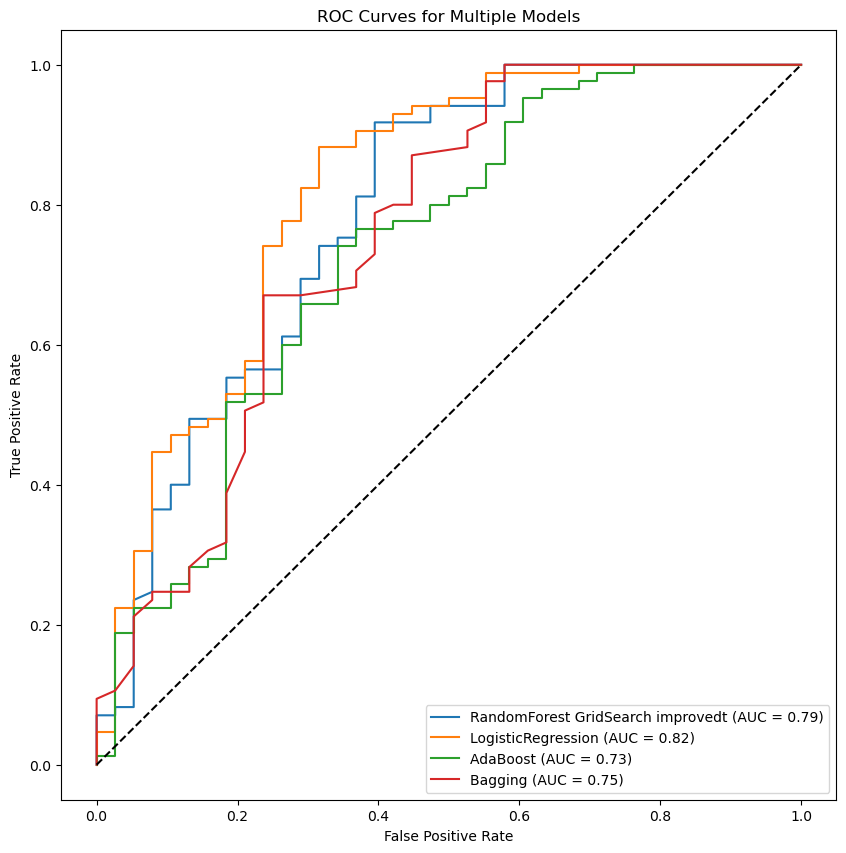

In [59]:
# Plot to visually compare the models
plt.figure(figsize=(10, 10))
models = [best_rf_model, lr_model, ada_clf, bag_clf]
model_names = ['RandomForest GridSearch improvedt', 'LogisticRegression', 'AdaBoost', 'Bagging']
for model, name in zip(models, model_names):
    y_test_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.show()